# **This notebook is prepared as a project for the reqirement of the course CSE440-Natural Language Processing II of Brac University.**

**In this notebook, we have used 3 different approaches for sentiment classification on a customized IMDB Dataset. Workflow--->**
* **Importing/installing necessary libraries**
* **EDA**
* **Text Data Preprocessing**
* **Loading a Pre-trained vector and making an Embedding matrix**
* **RNN Training and testing**
* **LSTM Training and testing**
* **BiLSTM Training and testing**
* **Result Visualization**

# Importing/installing necessary libraries

In [1]:
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('stopwords')

import matplotlib.pyplot as plt
import seaborn as sns

import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam

import os
import warnings

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Creating a dynamic data path**

In [2]:
'''input the path of the directory 
containing both files '''

dir = '/kaggle/input/'  

for dirname, _, filenames in os.walk(dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        if filename.endswith('.txt'):
            vecPath = os.path.join(dirname, filename)
        else:
            dataPath = os.path.join(dirname, filename)

/kaggle/input/imdb-for-440-project/glove.6B.100d.txt
/kaggle/input/imdb-for-440-project/imdb_440/IMDB Dataset.csv


# EDA

In [3]:
df = pd.read_csv(dataPath)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
print(df.dtypes)

# Check for missing values
print(df.isnull().sum())

review       object
sentiment    object
dtype: object
review       0
sentiment    0
dtype: int64


In [5]:
df.sentiment.unique()

array(['positive', 'negative'], dtype=object)

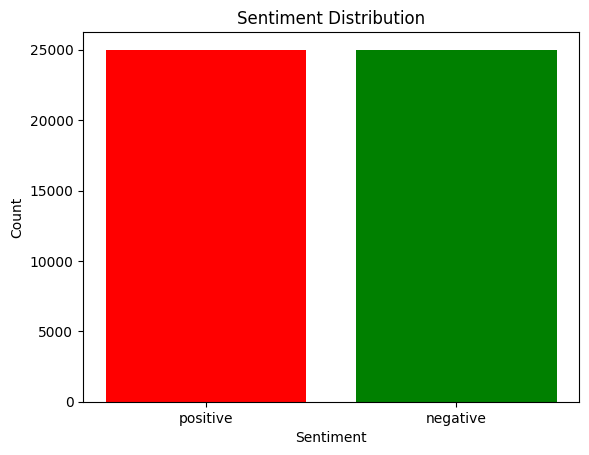

In [6]:
#data distribution
#balance check

sentiment_distribution = df['sentiment'].value_counts()

# Plotting the distribution
plt.bar(sentiment_distribution.index, sentiment_distribution.values, color=['red', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

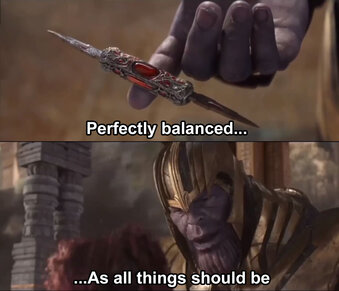

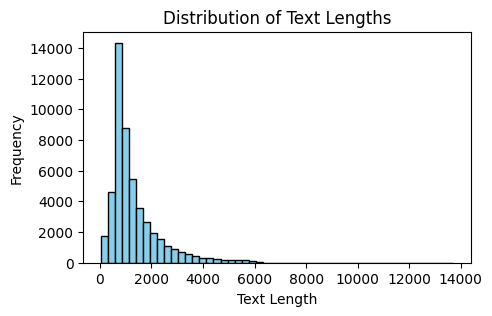

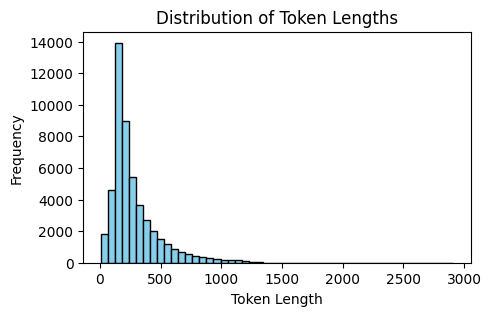

In [7]:
# Calculate text lengths
df['text_length'] = df['review'].apply(len)

# Plot histogram
plt.figure(figsize=(5, 3))
plt.hist(df['text_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Tokenize the text
df['token_length'] = df['review'].apply(lambda x: len(word_tokenize(x)))

# Plot histogram 
plt.figure(figsize=(5, 3))
plt.hist(df['token_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

# Preprocessing the text data

In [8]:
# binary encode sentiments
encoder = LabelEncoder()
df['sentiment'] = encoder.fit_transform(df['sentiment'])

def preprocess_text(text):
    #html tag handling
    text = re.sub(r'<[^>]+>', '', text)

    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = word_tokenize(text)

    #punctuation and stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]

#     stemmer = PorterStemmer()
#     tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)
df['cleaned_review'] = df['review'].apply(preprocess_text)

# Compare the two
print(df[['review', 'cleaned_review']].head())

                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  
0  one reviewers mentioned watching 1 oz episode ...  
1  wonderful little production filming technique ...  
2  thought wonderful way spend time hot summer we...  
3  basically family little boy jake thinks zombie...  
4  petter mattei love time money visually stunnin...  


# Loading GloVe and making an Embedding Matrix

In [9]:
def load_glove_vectors(glovePath):
    embedding_index = {}
    with open(glovePath, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs
    return embedding_index

# Load GloVe Vectors
glove_vectors = load_glove_vectors(vecPath)

# Tokenize, text ---> sequences
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_review'])  
sequences = tokenizer.texts_to_sequences(df['cleaned_review'])

# Create an embedding matrix
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_vectors.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

**Train-test split and padding**

In [10]:
X = sequences  
y = df['sentiment'].values 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Padding sequences
maxlen = 200  # Maximum length of all sequences
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# Training and testing on RNN

In [11]:
# Building the model
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=vocab_size, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=maxlen, 
                    trainable=False))
rnn_model.add(Flatten())  # Flatten the output of the embedding layer
rnn_model.add(Dense(10, activation='relu'))
rnn_model.add(Dense(1, activation='sigmoid'))  

# optimizer = Adam(learning_rate=1e-3)
rnn_model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          10018200  
                                                                 
 flatten (Flatten)           (None, 20000)             0         
                                                                 
 dense (Dense)               (None, 10)                200010    
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 10218221 (38.98 MB)
Trainable params: 200021 (781.33 KB)
Non-trainable params: 10018200 (38.22 MB)
_________________________________________________________________


In [12]:
# Training the model

history_rnn = rnn_model.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.2, batch_size=16)

Epoch 1/20
2000/2000 [==============================] - 10s 5ms/step - loss: 0.6049 - accuracy: 0.6844 - val_loss: 0.5419 - val_accuracy: 0.7501
Epoch 2/20
2000/2000 [==============================] - 9s 4ms/step - loss: 0.4746 - accuracy: 0.7846 - val_loss: 0.4915 - val_accuracy: 0.7749
Epoch 3/20
2000/2000 [==============================] - 9s 5ms/step - loss: 0.3970 - accuracy: 0.8248 - val_loss: 0.5033 - val_accuracy: 0.7719
Epoch 4/20
2000/2000 [==============================] - 10s 5ms/step - loss: 0.3476 - accuracy: 0.8463 - val_loss: 0.5762 - val_accuracy: 0.7654
Epoch 5/20
2000/2000 [==============================] - 10s 5ms/step - loss: 0.3165 - accuracy: 0.8598 - val_loss: 0.5773 - val_accuracy: 0.7653
Epoch 6/20
2000/2000 [==============================] - 10s 5ms/step - loss: 0.2898 - accuracy: 0.8711 - val_loss: 0.6094 - val_accuracy: 0.7601
Epoch 7/20
2000/2000 [==============================] - 10s 5ms/step - loss: 0.2694 - accuracy: 0.8779 - val_loss: 0.6529 - val_accu

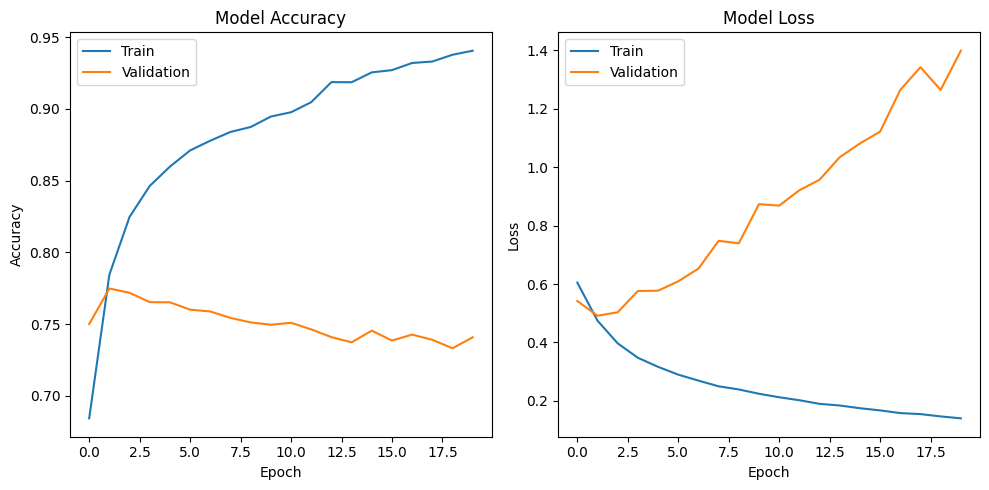

In [13]:
# Plot training and validation curves
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'])
plt.plot(history_rnn.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [14]:
#Testing on RNN

rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {rnn_accuracy:.4f}')

y_pred = rnn_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
cm_rnn = confusion_matrix(y_test, y_pred_binary) #conf mat for future visuals

rnn_model_f1 = f1_score(y_test, y_pred_binary)
print(f'F1 Score on Test Set: {rnn_model_f1:.4f}')

313/313 [==============================] - 1s 3ms/step - loss: 1.4866 - accuracy: 0.7305
Test Accuracy: 0.7305
313/313 [==============================] - 1s 3ms/step
F1 Score on Test Set: 0.7352


# Training and testing on LSTM(Unidirectional)

In [15]:
uni_LSTM = Sequential()
uni_LSTM.add(Embedding(input_dim=vocab_size, 
                       output_dim=embedding_dim, 
                       weights=[embedding_matrix], 
                       input_length=maxlen, 
                       trainable=False))
uni_LSTM.add(LSTM(10, activation='relu'))  # Unidirectional LSTM layer
uni_LSTM.add(Dense(1, activation='sigmoid'))  

optimizer = Adam(learning_rate=1e-3)
uni_LSTM.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
uni_LSTM.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 100)          10018200  
                                                                 
 lstm (LSTM)                 (None, 10)                4440      
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 10022651 (38.23 MB)
Trainable params: 4451 (17.39 KB)
Non-trainable params: 10018200 (38.22 MB)
_________________________________________________________________


In [16]:
#Training the uni_LSTM model 
'''saving the best model while training 
because of the exploding gradiant problem'''

model_checkpoint = ModelCheckpoint(filepath='/kaggle/working/uni_LSTM_best.h5', 
                                   monitor='val_loss', 
                                   save_best_only=True,
                                   mode='min',
                                   verbose=1)

history_uni_LSTM = uni_LSTM.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.2, batch_size=16, callbacks=[model_checkpoint])

Epoch 1/20
1999/2000 [============================>.] - ETA: 0s - loss: 3.0959 - accuracy: 0.5058
Epoch 1: val_loss improved from inf to 0.83297, saving model to /kaggle/working/uni_LSTM_best.h5
2000/2000 [==============================] - 91s 45ms/step - loss: 3.0948 - accuracy: 0.5058 - val_loss: 0.8330 - val_accuracy: 0.4921
Epoch 2/20
2000/2000 [==============================] - ETA: 0s - loss: 0.7403 - accuracy: 0.4963
Epoch 2: val_loss improved from 0.83297 to 0.71947, saving model to /kaggle/working/uni_LSTM_best.h5
2000/2000 [==============================] - 92s 46ms/step - loss: 0.7403 - accuracy: 0.4963 - val_loss: 0.7195 - val_accuracy: 0.5048
Epoch 3/20
1999/2000 [============================>.] - ETA: 0s - loss: 0.7158 - accuracy: 0.5043
Epoch 3: val_loss improved from 0.71947 to 0.71757, saving model to /kaggle/working/uni_LSTM_best.h5
2000/2000 [==============================] - 90s 45ms/step - loss: 0.7158 - accuracy: 0.5042 - val_loss: 0.7176 - val_accuracy: 0.5051
Ep

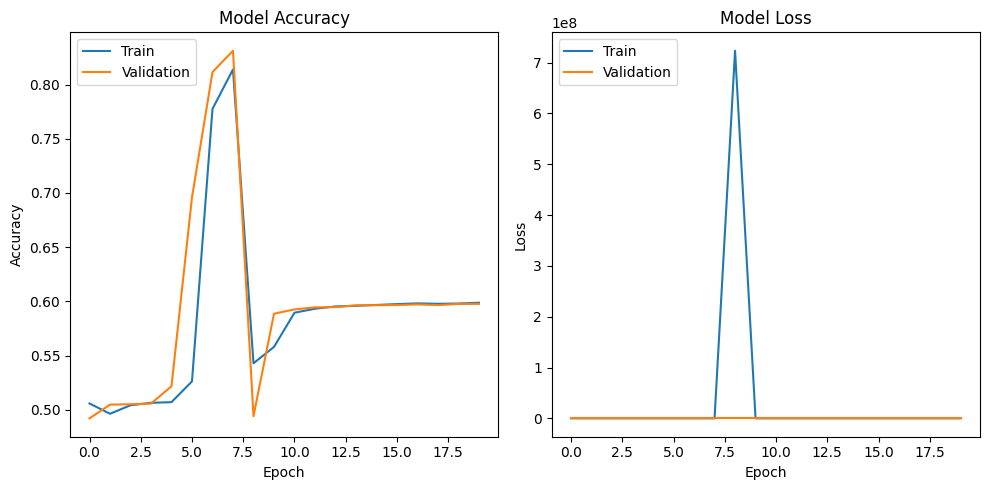

In [17]:
# Plot training and validation curves
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_uni_LSTM.history['accuracy'])
plt.plot(history_uni_LSTM.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_uni_LSTM.history['loss'])
plt.plot(history_uni_LSTM.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [18]:
#testing
uni_LSTM = load_model('/kaggle/working/uni_LSTM_best.h5')

uni_loss, uni_accuracy = uni_LSTM.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {uni_accuracy:.4f}')

y_pred = uni_LSTM.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
cm_uni_LSTM = confusion_matrix(y_test, y_pred_binary) #conf mat for future visuals

uni_LSTM_f1 = f1_score(y_test, y_pred_binary)
print(f'F1 Score on Test Set: {uni_LSTM_f1:.4f}')

313/313 [==============================] - 6s 17ms/step - loss: 0.3960 - accuracy: 0.8201
Test Accuracy: 0.8201
313/313 [==============================] - 5s 17ms/step
F1 Score on Test Set: 0.8135


# Training and testing on Bi LSTM

In [19]:
bi_LSTM = Sequential()
bi_LSTM.add(Embedding(input_dim=vocab_size, 
                      output_dim=embedding_dim, 
                      weights=[embedding_matrix], 
                      input_length=maxlen, 
                      trainable=False))
bi_LSTM.add(Bidirectional(LSTM(10, activation='relu')))  # Bidirectional LSTM layer
bi_LSTM.add(Dense(1, activation='sigmoid')) 

optimizer = Adam(learning_rate=1e-3)
bi_LSTM.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
bi_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 100)          10018200  
                                                                 
 bidirectional (Bidirection  (None, 20)                8880      
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 10027101 (38.25 MB)
Trainable params: 8901 (34.77 KB)
Non-trainable params: 10018200 (38.22 MB)
_________________________________________________________________


In [20]:
#Training the bi_LSTM model 
'''saving the best model while training 
because of the exploding gradiant problem'''

model_checkpoint = ModelCheckpoint(filepath='/kaggle/working/bi_LSTM_best.h5', 
                                   monitor='val_loss', 
                                   save_best_only=True,
                                   mode='min',
                                   verbose=1)

history_bi_LSTM = bi_LSTM.fit(X_train, y_train, epochs=20, verbose=1, validation_split=0.2, batch_size=16, callbacks=[model_checkpoint])

Epoch 1/20
2000/2000 [==============================] - ETA: 0s - loss: 0.7090 - accuracy: 0.5093
Epoch 1: val_loss improved from inf to 0.69019, saving model to /kaggle/working/bi_LSTM_best.h5
2000/2000 [==============================] - 128s 63ms/step - loss: 0.7090 - accuracy: 0.5093 - val_loss: 0.6902 - val_accuracy: 0.5067
Epoch 2/20
2000/2000 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.5297
Epoch 2: val_loss improved from 0.69019 to 0.68624, saving model to /kaggle/working/bi_LSTM_best.h5
2000/2000 [==============================] - 125s 62ms/step - loss: 0.6891 - accuracy: 0.5297 - val_loss: 0.6862 - val_accuracy: 0.5340
Epoch 3/20
2000/2000 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.5511
Epoch 3: val_loss improved from 0.68624 to 0.68224, saving model to /kaggle/working/bi_LSTM_best.h5
2000/2000 [==============================] - 124s 62ms/step - loss: 0.6835 - accuracy: 0.5511 - val_loss: 0.6822 - val_accuracy: 0.5530
Ep

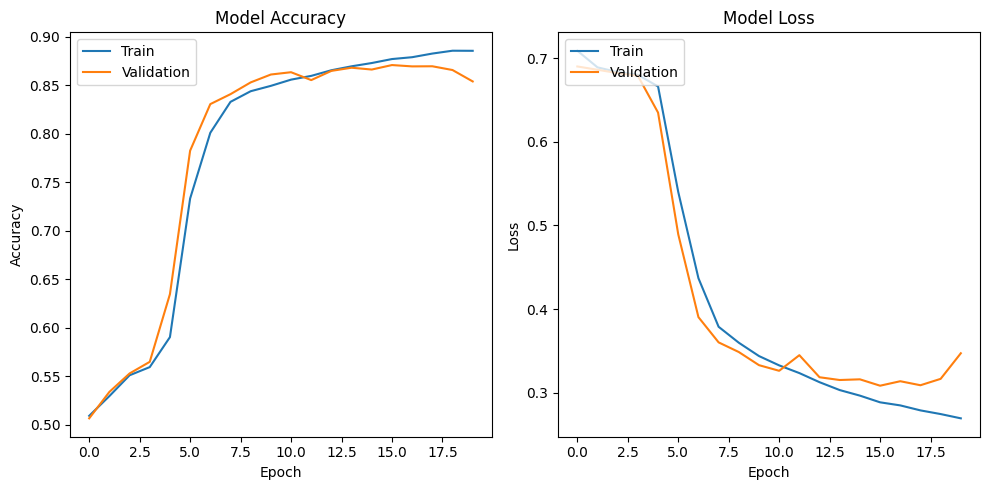

In [21]:
# Plot training and validation curves
plt.figure(figsize=(10, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_bi_LSTM.history['accuracy'])
plt.plot(history_bi_LSTM.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_bi_LSTM.history['loss'])
plt.plot(history_bi_LSTM.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [22]:
#testing
bi_LSTM = load_model('/kaggle/working/bi_LSTM_best.h5')

bi_loss, bi_accuracy = bi_LSTM.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {bi_accuracy:.4f}')

y_pred = bi_LSTM.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

f1 = f1_score(y_test, y_pred_binary)
print(f'F1 Score on Test Set: {f1:.4f}')

313/313 [==============================] - 7s 22ms/step - loss: 0.3164 - accuracy: 0.8599
Test Accuracy: 0.8599
313/313 [==============================] - 7s 20ms/step
F1 Score on Test Set: 0.8620


In [23]:
y_pred = bi_LSTM.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
cm_bi_LSTM = confusion_matrix(y_test, y_pred_binary) #conf mat for future visuals

bi_LSTM_f1 = f1_score(y_test, y_pred_binary)
print(f'F1 Score on Test Set: {bi_LSTM_f1:.4f}')

313/313 [==============================] - 6s 20ms/step
F1 Score on Test Set: 0.8620


# Visualizing the results

In [24]:
# All test metrics at a glance

data = {
    'Model': ['RNN', 'Uni-LSTM', 'Bi-LSTM'],
    'Accuracy': [rnn_accuracy, uni_accuracy, bi_accuracy],
    'F1 Score': [rnn_model_f1, uni_LSTM_f1, bi_LSTM_f1],
    'Loss': [rnn_loss, uni_loss, bi_loss]
}

df = pd.DataFrame(data)
print(df)

      Model  Accuracy  F1 Score      Loss
0       RNN    0.7305  0.735239  1.486553
1  Uni-LSTM    0.8201  0.813517  0.395991
2   Bi-LSTM    0.8599  0.862038  0.316423


**Training accuracy and loss**

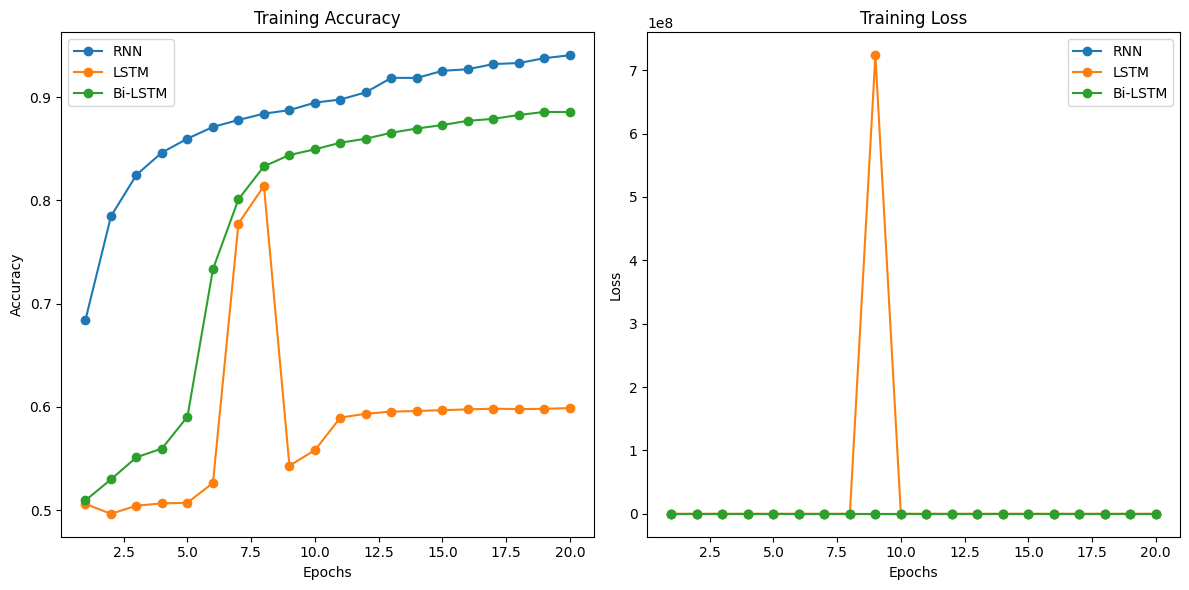

In [25]:
# Extracting information from history objects
epochs = range(1, len(history_rnn.history['accuracy']) + 1)

# Plotting Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, history_rnn.history['accuracy'], label='RNN', marker='o')
plt.plot(epochs, history_uni_LSTM.history['accuracy'], label='LSTM', marker='o')
plt.plot(epochs, history_bi_LSTM.history['accuracy'], label='Bi-LSTM', marker='o')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history_rnn.history['loss'], label='RNN', marker='o')
plt.plot(epochs, history_uni_LSTM.history['loss'], label='LSTM', marker='o')
plt.plot(epochs, history_bi_LSTM.history['loss'], label='Bi-LSTM', marker='o')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


**Visualization/Comparison with Bar charts**

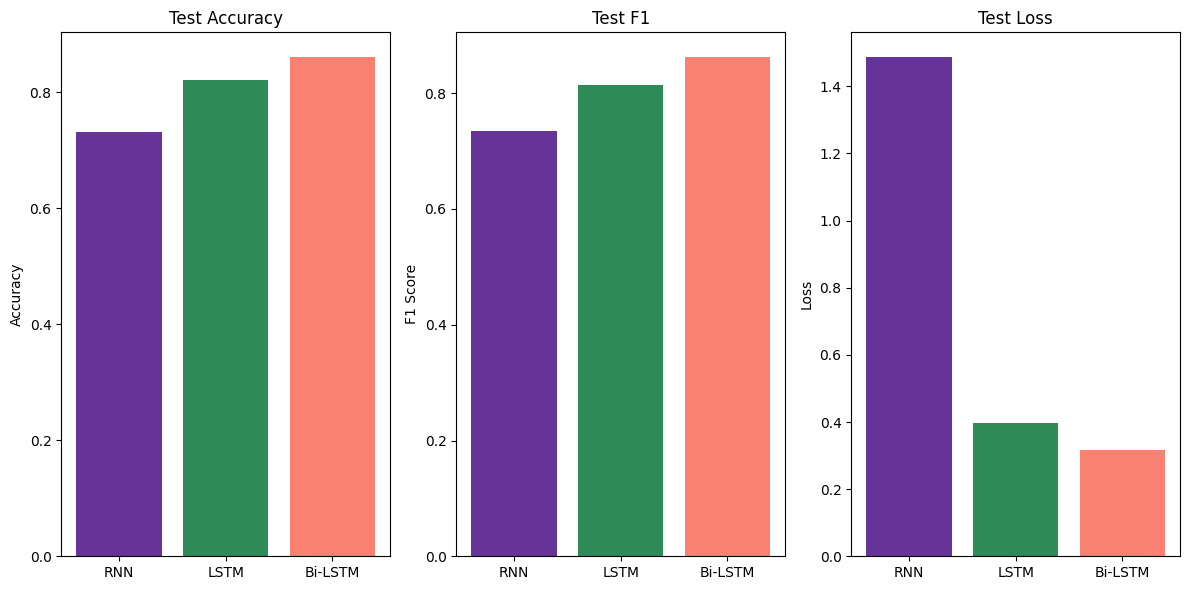

In [26]:
# Data
accuracy_data = [rnn_accuracy, uni_accuracy, bi_accuracy]
f1_data = [rnn_model_f1, uni_LSTM_f1, bi_LSTM_f1]
loss_data = [rnn_loss, uni_loss, bi_loss]
models = ['RNN', 'LSTM', 'Bi-LSTM']

# Plotting Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.bar(models, accuracy_data, color=['rebeccapurple', 'seagreen', 'salmon'])
plt.title('Test Accuracy')
plt.ylabel('Accuracy')

# Plotting f1
plt.subplot(1, 3, 2)
plt.bar(models, f1_data, color=['rebeccapurple', 'seagreen', 'salmon'])
plt.title('Test F1')
plt.ylabel('F1 Score')


# Plotting Loss
plt.subplot(1, 3, 3)
plt.bar(models, loss_data, color=['rebeccapurple', 'seagreen', 'salmon'])
plt.title('Test Loss')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


**Overall performance visualization with heatmaps**

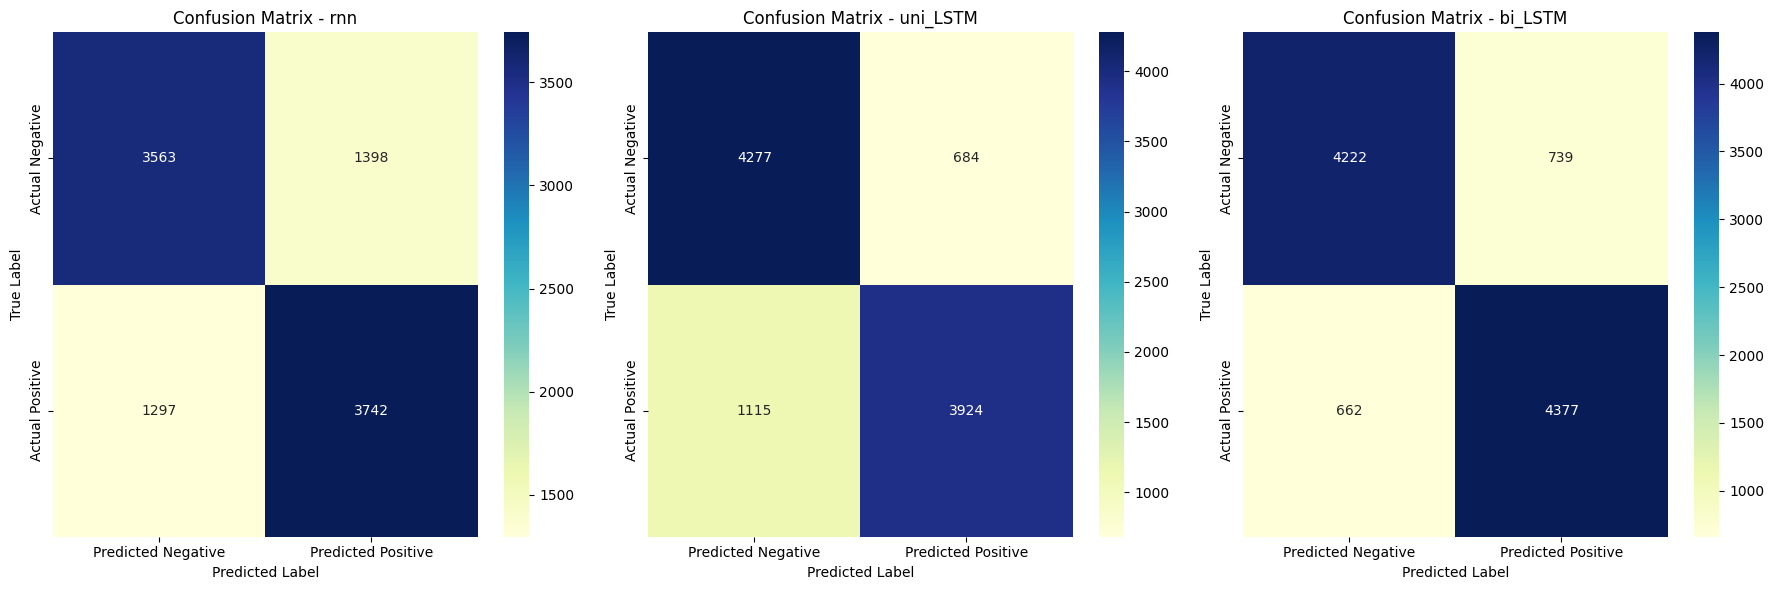

In [27]:
cms = [cm_rnn, cm_uni_LSTM, cm_bi_LSTM]
model_names = ['rnn', 'uni_LSTM', 'bi_LSTM']

plt.figure(figsize=(18, 6))

for i, cm in enumerate(cms, 1):
    plt.subplot(1, 3, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', 
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(f'Confusion Matrix - {model_names[i-1]}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()